# Retreival System

This is based heavily on the tutorial from https://huggingface.co/learn/cookbook/en/advanced_rag as recommended in the course. We should probably credit it.

Hyperparameters to test:


* embedding models
* distance strategies for vector store
* chunk size
* overlap size
* k value for top_k



In [1]:
!pip install -q langchain langchain-community transformers sentence-transformers faiss-gpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 83.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.8/255.8 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 407.7/407.7 kB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58

In [2]:
from langchain.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
import pandas as pd

In [4]:
# To get the value of the max sequence_length, we will query the underlying `SentenceTransformer` object used for embeddings
from sentence_transformers import SentenceTransformer
print(f"Model's maximum sequence length: {SentenceTransformer('all-mpnet-base-v2').max_seq_length}")

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Model's maximum sequence length: 384


In [7]:
# Load data
df = pd.read_csv('data.csv')

# Initialize embeddings
# embeddings = HuggingFaceEmbeddings(model_name='sentence-transformers/all-mpnet-base-v2')
embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-mpnet-base-v2",
    multi_process=True,
    model_kwargs={"device": "cuda"},
    encode_kwargs={"normalize_embeddings": True},  # Set `True` for cosine similarity
)

# Split text into chunks
TEXT_SEPARATORS = [
    "\n\n",
    "\n",
    "."
    " ",
    "",
]

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=384-64, # selected to stay under 384 max size for all-mpnet-base-v2
    chunk_overlap=50, # arbitrarily pick how much across chunks
    add_start_index=True,  # If `True`, includes chunk's start index in metadata
    strip_whitespace=True,  # If `True`, strips whitespace from the start and end of every document
    separators=TEXT_SEPARATORS,
)
texts = []
metadatas = []

for _, row in df.iterrows():
    try:
      chunks = text_splitter.split_text(row['text'])
      texts.extend(chunks)
      metadatas.extend([{'source': row['source']}] * len(chunks))
    except:
      print(f"source {row['source']} corrupted")

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


source https://onestoppgh.pittsburghpa.gov/pghprod/pub/lms/Login.aspx corrupted
source https://www.cmu.edu/dietrich/rss-feeds/news-rss.rss corrupted


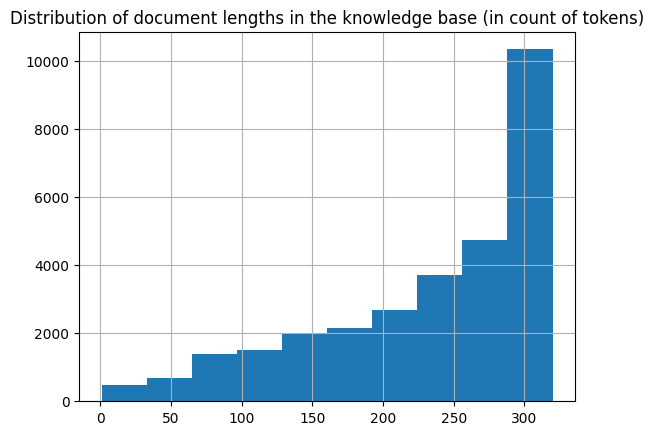

In [8]:
lengths = [len(text) for text in texts]

# Plot the distribution of text lengths, counted as the number of tokens
import matplotlib.pyplot as plt
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

In [11]:
# Create FAISS index
from langchain_community.vectorstores.utils import DistanceStrategy

vectorstore = FAISS.from_texts(texts, embeddings, metadatas=metadatas, distance_strategy=DistanceStrategy.COSINE)

In [12]:
# Define retrieval function
def retrieve_top_k(query, k=5):
    results = vectorstore.similarity_search(query, k=k)
    return [(res.page_content, res.metadata['source']) for res in results]

In [15]:
# Example usage
query = "When is CMU's Spring Carnival Weekend 2025?"
top_chunks = retrieve_top_k(query, k=5)
for i, (text, source) in enumerate(top_chunks, 1):
    print(f"\nResult {i}:")
    print(f"Source: {source}")
    print(f"Text: {text}\n")


Result 1:
Source: Carnagie Mellon University Alumni
Text: e with CMU Engage with CMU \u203a Alumni \u203a Attend an Event \u203a Campus Events \u203a Spring Carnival \u203a\u00a0             Spring Carnival Featured Highlights Spring Carnival 2024 April 11-14 Booth | Buggy | MOBOT | Tartans on the Rise For more than 100 years, Carnival has been one the most anticipated weeken


Result 2:
Source: Carnagie Mellon University Alumni
Text: \u203a Attend an Event \u203a Campus Events \u203a\u00a0             Spring Carnival Spring Carnival Weekend April 3-5, 2025 For more than 100 years, Carnival has been one the most anticipated weekends of the year with Tartans around the world coming together to celebrate this oh-so-CMU tradition


Result 3:
Source: Carnagie Mellon University Alumni
Text: n Event \u203a Campus Events \u203a\u00a0             Reunion Reunion Weekend at Spring Carnival April 3-5, 2025 Save the date for CMU's most-anticipated weekend, which offers an array of special experi